### Sample code for Comparing NILM algorithms

In [118]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

rcParams['figure.figsize'] = (13, 6)

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, FHMM, MLE

### Dividing data into train and test set

In [119]:
train = DataSet('/home/shifona/Downloads/mini_project/REDD/redd.h5')
test = DataSet('/home/shifona/Downloads/mini_project/REDD/redd.h5')

Let us use building 1 for demo purposes

In [120]:
building = 2

Let's split data at April 30th

In [121]:
train.set_window(end="30-4-2011")
test.set_window(start="30-4-2011")


train_elec = train.buildings[2].elec
test_elec = test.buildings[2].elec

### Selecting top-5 appliances

In [122]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

9/9 ElecMeter(instance=11, building=2, dataset='REDD', appliances=[Appliance(type='waste disposal unit', instance=1)])

In [123]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
)

In [124]:

z=top_5_train_elec

### Training and disaggregation

In [125]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}

    for i, chunk in enumerate(test_elec.mains().load(sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Only use the meters that we trained on (this saves time!)    
            gt[i][meter] = meter.load(sample_period=sample_period).next()
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in gt[i].iteritems()}, index=gt[i].values()[0].index).dropna()
        
    # If everything can fit in memory
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Having the same order of columns
    gt_overall = gt_overall[pred_overall.columns]
    
    #Intersection of index
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.ix[common_index_local]
    pred_overall = pred_overall.ix[common_index_local]
    appliance_labels = [m.label() for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [126]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 120
num_states_dict = {}
num_states_dict[z['light']]=7
num_states_dict[z['microwave']]=2
num_states_dict[z['fridge']]=3
num_states_dict[z['dish washer']]=2
num_states_dict[z['sockets',2]]=1
for clf_name, clf in classifiers.iteritems():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    if  clf_name == "FHMM":
        clf.train(top_5_train_elec, sample_period=sample_period,num_states_dict=num_states_dict)
    else:    
        clf.train(top_5_train_elec, sample_period=sample_period)
    gt, predictions[clf_name] = predict(clf, test_elec, 120, train.metadata['timezone'])
   
    

********************
FHMM
********************
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=2, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=10, building=2, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=2, dataset='REDD')     
Done loading data all meters for this chunk.
********************
CO
********************
Training model for submeter 'ElecMeter(instance=4, building=2, dataset='REDD', appliances=[Appliance(type='light', inst

In [127]:
def compute_rmse(gt, pred):
    from sklearn.metrics import mean_squared_error
    rms_error = {}
    for appliance in gt.columns:
        rms_error[appliance] = np.sqrt(mean_squared_error(gt[appliance], pred[appliance]))
    return pd.Series(rms_error)
def compute_acc(gt, pred):
    import math
    pd_ = {}
    gt_ = {}
    rerror = {}
    lt = 0
    leng = {}
    napp = []
    for appliance in gt.columns:
        t = len(pred[appliance])
        if lt<t:
            lt = t
            napp = []
        if lt==t:
            napp.append(appliance)
        leng[appliance]= t
        #print(str(appliance) + " : "+str(t))


    for appliance in napp:
        if (leng[appliance] < lt):
            continue
        #print(appliance)
        gt_[appliance] = gt[appliance]
        pd_[appliance] = pred[appliance]
        #print(str(len(pd_[appliance]))+", "+str(len(gt_[appliance])))
    
    #print(napp)
    #print(lt)
    s = 0
    sd = 0
    for i in range(lt):
        for appliance in napp:
            #if isinstance( pd[appliance][0], ( int, long ) ):
            #print( pd_[appliance] )
            #print(i)
            s = s + abs(pd_[appliance][i]-gt_[appliance][i])
            sd = sd + gt_[appliance][i]

    acc_ = 1 - (1.0*s)/sd/2
    #print(acc)
    #print(pd)
    return acc_
    #return pd.Series(rms_error)

In [128]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = compute_rmse(gt, predictions[clf_name])
rmse = pd.DataFrame(rmse)

In [129]:
rmse

,CO,FHMM
Dish washer,172.870804,179.134920
Fridge,122.524597,54.682992
Light,51.992783,70.372251
Microwave,108.655052,17.499995
Sockets,111.319420,85.064394


In [130]:
accu = {}
for clf_name in classifiers.keys():
    accu[clf_name] = compute_acc(gt, predictions[clf_name])
print(accu)

{'FHMM': 0.58152743756887837, 'CO': 0.082948506873335215}


In [131]:
import pandas as pd
def compute_accind(gt, pred):
    import math
    pd_ = {}
    gt_ = {}
    rerror = {}
    lt = 0
    leng = {}
    napp = []
    for appliance in gt.columns:
        t = len(pred[appliance])
        if lt<t:
            lt = t
            napp = []
        if lt==t:
            napp.append(appliance)
        leng[appliance]= t
        #print(str(appliance) + " : "+str(t))


    for appliance in napp:
        if (leng[appliance] < lt):
            continue
        #print(appliance)
        gt_[appliance] = gt[appliance]
        pd_[appliance] = pred[appliance]
        #print(str(len(pd_[appliance]))+", "+str(len(gt_[appliance])))
    
    #print(napp)
    #print(lt)
    acc = {}
    for appliance in napp:
        s = 0
        sd = 0
        for i in range(lt):
            #if isinstance( pd[appliance][0], ( int, long ) ):
            #print( pd_[appliance] )
            #print(i)
            s = s + abs(pd_[appliance][i]-gt_[appliance][i])
            sd = sd + gt_[appliance][i]
        deno = abs(sd*2)
        num = abs(1.0*s)
        #if num > deno:
        #    (num,deno) = (deno,num)
        acc_ = num/deno
        #acc_ = deno/abs(num-deno)
        acc[appliance] = acc_
    #print(acc)
    #print(pd)
    return pd.Series(acc)
    #return pd.Series(rms_error)
accu = {}
for clf_name in classifiers.keys():
    accu[clf_name] = compute_accind(gt, predictions[clf_name])
print(pd.DataFrame(accu))

                   CO      FHMM
Dish washer  4.896329  1.413068
Fridge       0.460283  0.102827
Light        0.909755  1.581793
Microwave    0.974200  0.202519
Sockets      0.790019  0.976981


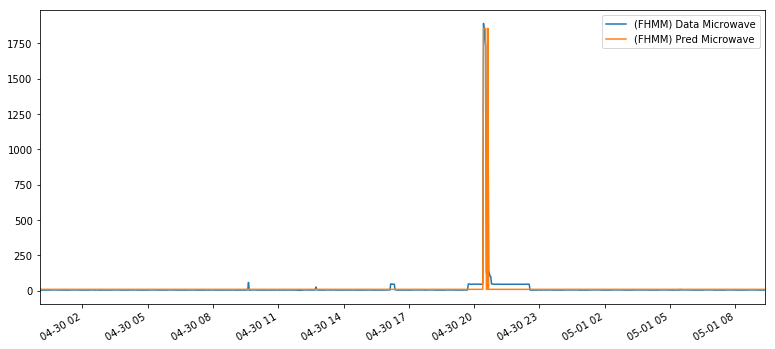

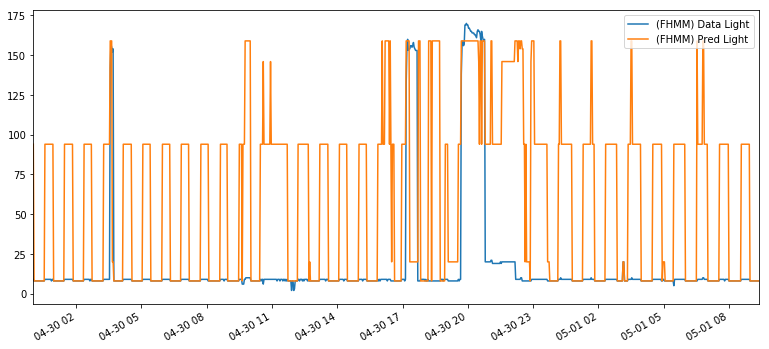

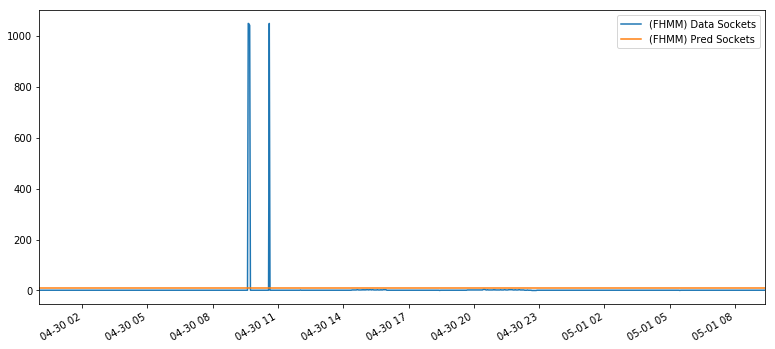

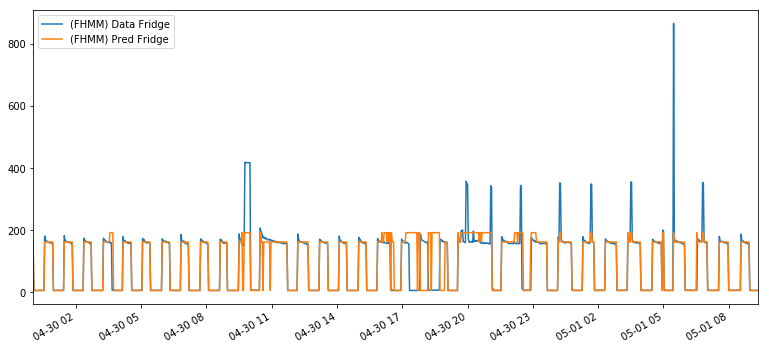

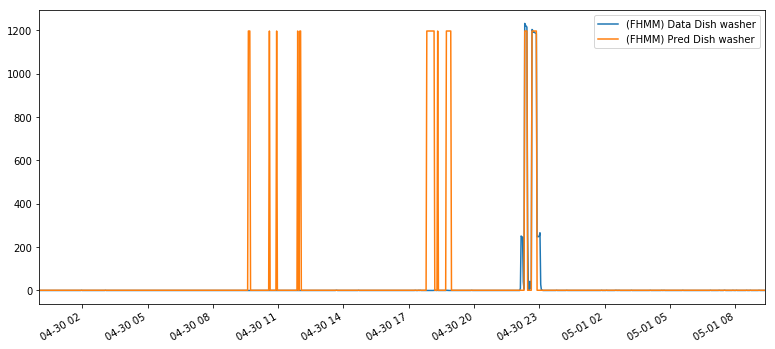

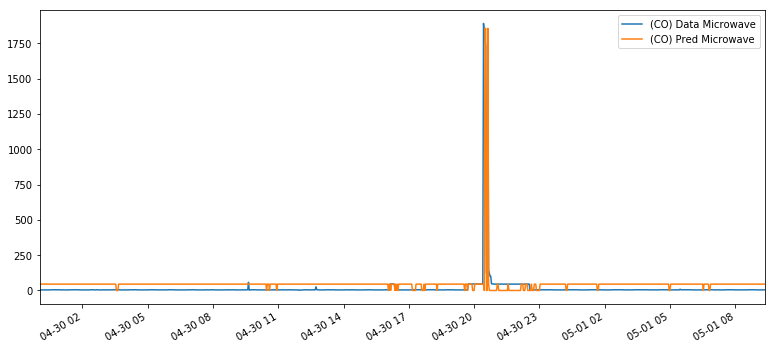

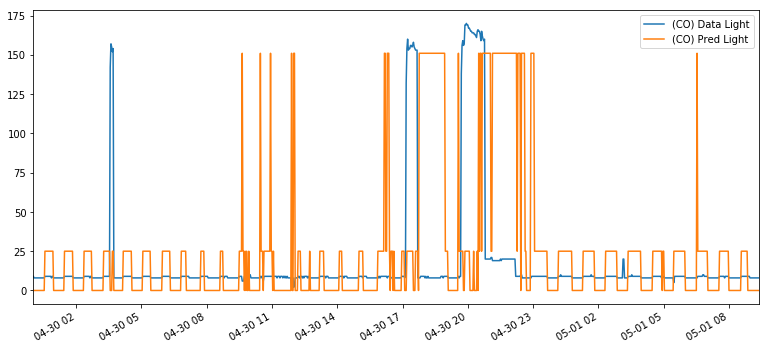

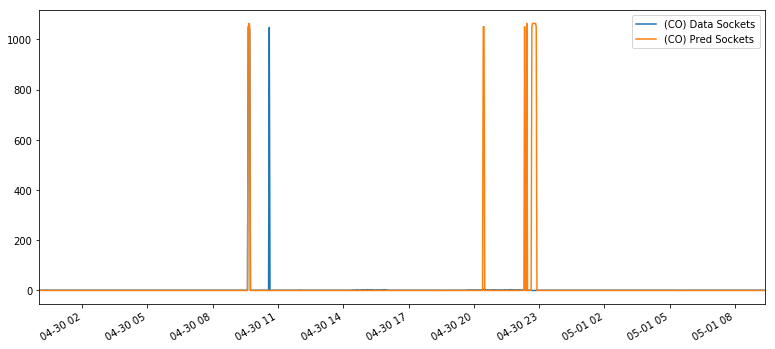

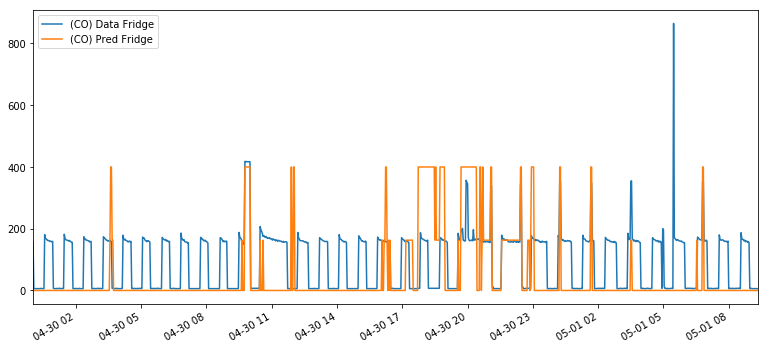

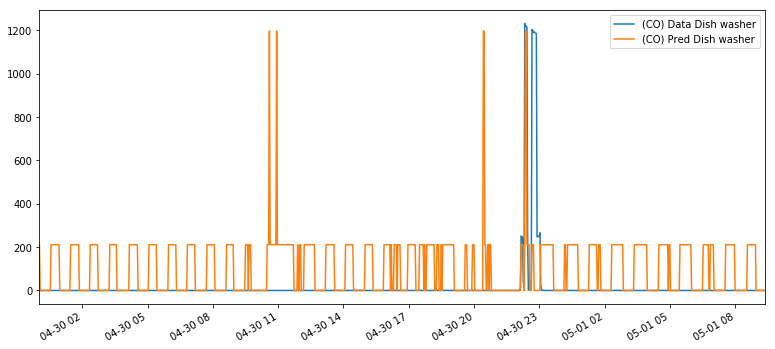

In [132]:
i=0
for clf_name in classifiers.keys():
    pd=predictions[clf_name]
    for app in gt.columns:
        plt.figure(i)
        i=i+1
        gt[app].head(1000).plot(label="("+clf_name+") Data "+str(app))
        pd[app].head(1000).plot(label="("+clf_name+") Pred "+str(app))
        plt.legend()